In [1]:
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [2]:
"""
Code to load model from here:
https://wandb.ai/jack-morris/emb-inv-1/runs/dc72e8b9c01bd27b0ed1c2def90bcee5/overview?workspace=user-jxmorris12

TODO: abstract this into analyze_utils function like load_trainer_from_checkpoint.
"""
import os
import shlex

import datasets
import torch
from transformers import AutoTokenizer, HfArgumentParser, set_seed
from transformers.trainer_utils import get_last_checkpoint

from collator import CustomCollator
from data_helpers import load_dpr_corpus, NQ_DEV, NQ_TRAIN
from models import load_encoder_decoder, load_embedder_and_tokenizer, InversionModel
from run_args import ModelArguments, DataTrainingArguments, TrainingArguments
from tokenize_data import tokenize_function
from trainers import InversionTrainer

#############################################################################

WANDB_ARGS_STR = '--per_device_train_batch_size 128 --per_device_eval_batch_size 128 --max_seq_length 128 --model_name_or_path t5-base --embedder_model_name gtr_base --num_repeat_tokens 16 --embedder_no_grad True --exp_group_name mar17-baselines --learning_rate 0.0003 --freeze_strategy none --embedder_fake_with_zeros False --use_frozen_embeddings_as_input False --num_train_epochs 24 --max_eval_samples 500 --eval_steps 25000 --warmup_steps 100000 --bf16=1 --use_wandb=1'
args = shlex.split(WANDB_ARGS_STR)

parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
model_args, data_args, training_args = parser.parse_args_into_dataclasses(args=args)

checkpoint = '/home/jxm3/research/retrieval/inversion/saves/c9a30cba01655d513e46040f949f6da7'
training_args = torch.load(os.path.join(checkpoint, 'training_args.bin'))
training_args.use_wandb = False

set_seed(training_args.seed)

#############################################################################
tokenizer = AutoTokenizer.from_pretrained(
    model_args.model_name_or_path,
    padding=True,
    truncation='max_length',
    max_length=model_args.max_seq_length,
)
embedder, embedder_tokenizer = load_embedder_and_tokenizer(
    name=model_args.embedder_model_name
)
model = InversionModel(
    embedder=embedder,
    embedder_tokenizer=embedder_tokenizer,
    tokenizer=tokenizer,
    encoder_decoder=load_encoder_decoder(
        model_name=model_args.model_name_or_path
    ),
    num_repeat_tokens=model_args.num_repeat_tokens,
    embedder_no_grad=model_args.embedder_no_grad,
    freeze_strategy=model_args.freeze_strategy,
)
model._keys_to_ignore_on_save = []

#############################################################################

text_column_name = "text"

raw_datasets = datasets.DatasetDict({
    "train": load_dpr_corpus(NQ_TRAIN),
    "validation": load_dpr_corpus(NQ_DEV),
})
column_names = list(raw_datasets["train"].features)
tokenized_datasets = raw_datasets.map(
    tokenize_function(tokenizer, embedder_tokenizer, text_column_name, model_args.max_seq_length),
    batched=True,
    num_proc=training_args.dataloader_num_workers,
    remove_columns=column_names,
    load_from_cache_file=not data_args.overwrite_cache,
    desc="Running tokenizer on dataset",
)
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]

if data_args.max_eval_samples is not None:
    max_eval_samples = min(len(eval_dataset), data_args.max_eval_samples)
    eval_dataset = eval_dataset.select(range(max_eval_samples))


#############################################################################

# Initialize our Trainer
trainer = InversionTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=CustomCollator(tokenizer=tokenizer),
)

# *** Evaluation ***
checkpoint = get_last_checkpoint('/home/jxm3/research/retrieval/inversion/saves/8631b1c05efebde3077d16c5b99f6d5e/dc72e8b9c01bd27b0ed1c2def90bcee5') # a checkpoint
trainer._load_from_checkpoint(checkpoint)

os.environ["WANDB_DISABLED"] = "true"
max_eval_samples = data_args.max_eval_samples if data_args.max_eval_samples is not None else len(eval_dataset)

metrics = trainer.evaluate()
metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))

print("metrics:", metrics)

There were missing keys in the checkpoint model loaded: ['embedder._orig_mod.embed_tokens.weight', 'embedder._orig_mod.block.0.layer.0.SelfAttention.q.weight', 'embedder._orig_mod.block.0.layer.0.SelfAttention.k.weight', 'embedder._orig_mod.block.0.layer.0.SelfAttention.v.weight', 'embedder._orig_mod.block.0.layer.0.SelfAttention.o.weight', 'embedder._orig_mod.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'embedder._orig_mod.block.0.layer.0.layer_norm.weight', 'embedder._orig_mod.block.0.layer.1.DenseReluDense.wi.weight', 'embedder._orig_mod.block.0.layer.1.DenseReluDense.wo.weight', 'embedder._orig_mod.block.0.layer.1.layer_norm.weight', 'embedder._orig_mod.block.1.layer.0.SelfAttention.q.weight', 'embedder._orig_mod.block.1.layer.0.SelfAttention.k.weight', 'embedder._orig_mod.block.1.layer.0.SelfAttention.v.weight', 'embedder._orig_mod.block.1.layer.0.SelfAttention.o.weight', 'embedder._orig_mod.block.1.layer.0.layer_norm.weight', 'embedder._orig_mod.block.1.layer.1.

generating from val:   0%|                                                                                 | 0/62 [00:00<?, ?it/s]/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:90: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Alonzo Mourning Alonzo Harding Mourning Jr. (born December 19, 1969) is an American retired professional basketball player who played in the National Basketball Association (NBA). He was a center and left guard for the Miami Heat, Los Angeles Lakers, and Atlanta Hawks. After playing college basketball at the University of Arizona, Mourning became known as "Motionary" after a ten-year career in which he averaged a career-high.276. Mourning was named to the All-NBA Second Team twice
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourning played at center. Following his college basketball career at Georgetown University, his tenacity on defense twice earned him NBA Defensive Player of the Year Award and perennially placed him on the NBA All-Defensive Team. Mourning made a comeback after undergoing a kidn

metrics: {'eval_loss': 2.31308650970459, 'eval_bleu_score': 11.856027778443329, 'eval_accuracy': 0.5111202116935484, 'eval_perplexity': 10.105567501104156, 'eval_runtime': 125.0505, 'eval_samples_per_second': 3.998, 'eval_steps_per_second': 0.504, 'eval_samples': 500}


Process ForkProcess-8:
Process ForkProcess-6:
Process ForkProcess-7:
Process ForkProcess-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jxm3/.conda/envs/torch/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jxm3/.conda/envs/torch/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jxm3/.conda/envs/torch/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jxm3/.conda/envs/torch/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jxm3/.conda/envs/torch/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jxm3/.conda/envs/torch/lib/python3.9/concurrent/futures/process.py", line 237, in _process_worker
    call_item

In [3]:
trainer.gen_kwargs = {
    'max_length': 128,
    "early_stopping": True,
    # "no_repeat_ngram_size": 3,
    # From CtRL paper: We find that using a greedy sampling 
    # and θ ≈ 1.2 yields a good balance between truthful generation
    # and lack of repetition (arxiv.org/abs/1909.05858)
    "repetition_penalty": 1.2,
    "num_beams": 1,
    'do_sample': False,
}
metrics = trainer.evaluate()
print("metrics:", metrics)

Alonzo Mourning Alonzo Harding Mourning Jr. (born December 19, 1969) is an American retired professional basketball player who played in the National Basketball Association (NBA). He was a center and left guard for the Miami Heat, Los Angeles Lakers, and Atlanta Hawks. After playing college basketball at the University of Arizona, Mourning became known as "Motionary" after a ten-year career in which he averaged a career-high.276. Mourning was named to the All-NBA Second Team twice
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourning played at center. Following his college basketball career at Georgetown University, his tenacity on defense twice earned him NBA Defensive Player of the Year Award and perennially placed him on the NBA All-Defensive Team. Mourning made a comeback after undergoing a kidn

metrics: {'eval_loss': 2.31308650970459, 'eval_bleu_score': 11.856027778443329, 'eval_accuracy': 0.5111202116935484, 'eval_perplexity': 10.105567501104156, 'eval_runtime': 104.5122, 'eval_samples_per_second': 4.784, 'eval_steps_per_second': 0.603}


In [61]:
from tqdm.notebook import trange

trainer.args.per_device_eval_batch_size = 128

d = trainer.get_eval_dataloader()
batch = next(iter(d))
batch['input_ids'].shape

torch._dynamo.config.verbose = True
trainer.model.eval()

gen_kwargs = trainer.gen_kwargs
gen_kwargs["temperature"] = 0.1
gen_kwargs["do_sample"] = True

torch.set_grad_enabled(False)
num_generations = 1000

input_embs = trainer.model.call_embedding_model(
    input_ids=batch['embedder_input_ids'].cuda(),
    attention_mask=batch['embedder_attention_mask'].cuda(),
)

all_data = []
for i in trange(num_generations):
    for temp in [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 10.0]:
        gen_kwargs["temperature"] = temp
        outputs = trainer.model.generate(
            inputs={k: v.cuda() for k,v in batch.items()},
            generation_kwargs=gen_kwargs
        )[:, 1:]
        # print(f"[t={temp}] outputs[0]:", trainer.model.embedder_tokenizer.decode(outputs[0]))
        output_embs = trainer.model.call_embedding_model(
            input_ids=outputs,
            attention_mask=torch.ones_like(outputs),
        )
        sims = torch.nn.CosineSimilarity(dim=1)(input_embs, output_embs)
        all_data.extend(
            [[j, output.cpu().tolist(), sim.cpu().item(), temp] for j, (output, sim) in enumerate(zip(outputs, sims))]
        )

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

df = pd.DataFrame(all_data, columns=["element_idx", "output", "sim", "temp"])
print(len(df))
df.head()

In [80]:
df.to_pickle("sampled_outputs.p")

In [64]:
len(df)

896000

<AxesSubplot:xlabel='temp', ylabel='sim'>

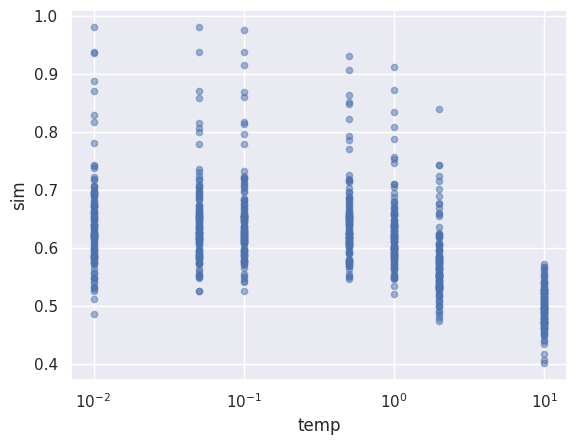

In [79]:
df[["element_idx", "sim", "temp"]].groupby(["element_idx", "temp"]).median().reset_index().plot(kind="scatter", x="temp", y="sim", logx=True, alpha=0.5)

<AxesSubplot:xlabel='temp'>

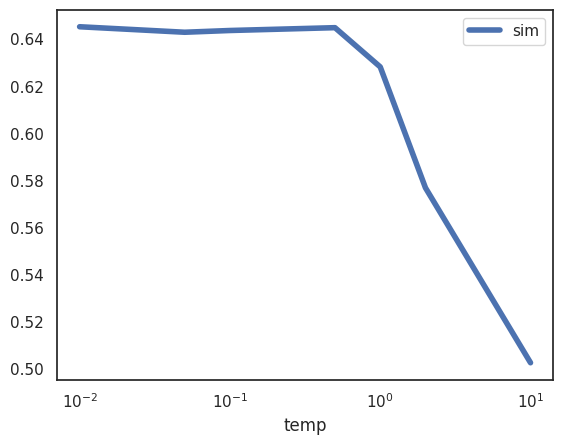

In [89]:
sns.set(style="white")
df[["element_idx", "sim", "temp"]].groupby(["element_idx", "temp"]).mean().reset_index().groupby("temp").mean().reset_index().plot(kind="line", x="temp", y="sim", logx=True, lw=4)

<AxesSubplot:xlabel='temp', ylabel='sim'>

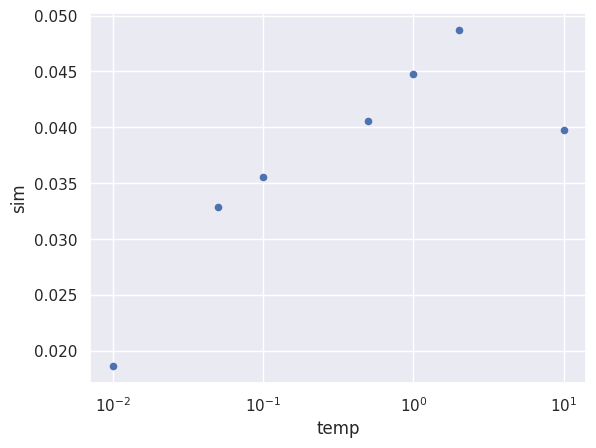

In [83]:
df[["element_idx", "sim", "temp"]].groupby(["element_idx", "temp"]).std().reset_index().groupby("temp").mean().reset_index().plot(kind="scatter", x="temp", y="sim", logx=True)

In [75]:
df.groupby("element_idx").std()["sim"].sort_values()

element_idx
62     0.029072
42     0.030406
44     0.032298
37     0.032741
30     0.032835
         ...   
113    0.148279
73     0.149537
84     0.150431
12     0.160622
105    0.177844
Name: sim, Length: 128, dtype: float64

In [69]:
trainer.model.embedder_tokenizer.decode([16902, 31676, 16902, 31676, 41, 7473, 2083])

'Marco Dawson Marco Dawson (born February'

In [76]:
trainer.model.embedder_tokenizer.decode(df[df["element_idx"] == 12].sort_values(by="sim", ascending=False).iloc[0]["output"])

'the Coalition Party of Ontario under the leadership of former NDP leader James Ames who ran as a new party called The Reformed Alliance with former NDP leader James Gault as its leader and former CPP leader LaRoie Appelle as its deputy leader. In the 2015 federal election, the Ontario New Democratic Party announced a new political party called Crossroads Reform Party which won all seats in the provincial assembly in the 2015 federal election. The party has had no formal affiliation with any political parties in Ontario since the 2013 election, and its most recent leader, Aonie Brown, announced his</s>'

In [77]:
trainer.model.embedder_tokenizer.decode(batch["embedder_input_ids"][12])

'Crossroads Forum, the Family Coalition Party of Ontario leadership via its newly elected party leader James Gault, deputy leader and director of communications Eric Ames, president Lynne Scime led a move to combine the original traditional moral values of the FCP with the democratic reform principles of the RPO into a new rebranded party called the New Reform Party of Ontario. However, the new party was deregistered by Elections Ontario as of January 2016, after only running once in the Simcoe North byelection in 2015 where Gault and New Reform, was defeated by Ontario PC leader Patrick Brown who won</s>'